In [1]:
# 工具包
import torch
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import random
import math

## 检测dataset 框架

In [2]:
class CustomerDataset(torch.utils.data.Dataset):

    def __init__(self):
        """对象初始化"""
        pass
    
    def __len__(self):
        """返回数据集大小"""
        pass

    def __getitem__(self, index):
        """定义数据集迭代器"""
        pass

    def preprocess_img_boxes(self, image, boxes):
        """图片和标签的处理"""
        pass
    
    def collate_fn(self, image, boxes, classes):
        """标签对齐"""
        pass

## VOCDataset() 实现

### 对象初始化  \_\_init__()

In [3]:
class VOCDataset(torch.utils.data.Dataset):
    
    CLASSES_NAME = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )

    def __init__(self, root_dir, resize_size=[800, 1333], split='trainval', use_difficult=False, is_train=True,
                 augment=None):
        """初始化主要工作：
            0）告知文件路径
            1）self.img_ids 图片名称列表
            2）self.name2id 标签类别到整数的映射字典
        """
        self.root = root_dir
        self.imgset = split
        self.use_difficult = use_difficult
        
        # %s 字符串格式符 字符串作为模板。
        self._annopath = os.path.join(self.root, "Annotations", "%s.xml") ;print(self._annopath)
        self._imgpath = os.path.join(self.root, "JPEGImages", "%s.jpg");print(self._imgpath)
        self._imgsetpath = os.path.join(self.root, "ImageSets", "Main", "%s.txt"); print(self._imgsetpath)
        print('=================================')
        
        with open(self._imgsetpath % self.imgset) as f:
            self.img_ids = f.readlines(); print(self.img_ids)
        
        self.img_ids = [x.strip() for x in self.img_ids]; print(self.img_ids)
        print('=================================')
        
        self.name2id = dict(zip(VOCDataset.CLASSES_NAME, range(len(VOCDataset.CLASSES_NAME)))); print(self.name2id)
        self.id2name = {v: k for k, v in self.name2id.items()};print(self.id2name)
        
        self.resize_size = resize_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        self.train = is_train
        self.augment = augment
        
        
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData')

/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/Annotations/%s.xml
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/JPEGImages/%s.jpg
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/ImageSets/Main/%s.txt
['2008_000002\n', '2008_000003\n', '2008_000007\n', '2008_000008\n', '2008_000009\n']
['2008_000002', '2008_000003', '2008_000007', '2008_000008', '2008_000009']
{'__background__ ': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}
{0: '__background__ ', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmoni

### 定义对象长度  \_\_len__()

In [5]:
class VOCDataset(torch.utils.data.Dataset):
    
    CLASSES_NAME = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )

    def __init__(self, root_dir, resize_size=[800, 1333], split='trainval', use_difficult=False, is_train=True,
                 augment=None):
        """初始化主要工作：
            0）告知文件路径
            1）self.img_ids 图片名称列表
            2）self.name2id 标签类别到整数的映射字典
        """
        self.root = root_dir
        self.imgset = split
        self.use_difficult = use_difficult
        
        # %s 字符串格式符 字符串作为模板。
        self._annopath = os.path.join(self.root, "Annotations", "%s.xml")
        self._imgpath = os.path.join(self.root, "JPEGImages", "%s.jpg")
        self._imgsetpath = os.path.join(self.root, "ImageSets", "Main", "%s.txt")
        
        with open(self._imgsetpath % self.imgset) as f:
            self.img_ids = f.readlines()
        self.img_ids = [x.strip() for x in self.img_ids]

    
        self.name2id = dict(zip(VOCDataset.CLASSES_NAME, range(len(VOCDataset.CLASSES_NAME))))
        self.id2name = {v: k for k, v in self.name2id.items()}
        
        self.resize_size = resize_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        self.train = is_train
        self.augment = augment
        
    def __len__(self):
        return len(self.img_ids)
    
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData')
len(dataset)

5

### 定义对象迭代 \_\_getitem__()
#### 不做数据增强
直接拿到图片和标签，不做数据增强处理

In [6]:
class VOCDataset(torch.utils.data.Dataset):
    
    CLASSES_NAME = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )

    def __init__(self, root_dir, resize_size=[800, 1333], split='trainval', use_difficult=False, is_train=True,
                 augment=None):
        """初始化主要工作：
            0）告知文件路径
            1）self.img_ids 图片名称列表
            2）self.name2id 标签类别到整数的映射字典
        """
        self.root = root_dir
        self.imgset = split
        self.use_difficult = use_difficult
        
        # %s 字符串格式符 字符串作为模板。
        self._annopath = os.path.join(self.root, "Annotations", "%s.xml")
        self._imgpath = os.path.join(self.root, "JPEGImages", "%s.jpg")
        self._imgsetpath = os.path.join(self.root, "ImageSets", "Main", "%s.txt")
        
        with open(self._imgsetpath % self.imgset) as f:
            self.img_ids = f.readlines()
        self.img_ids = [x.strip() for x in self.img_ids]

    
        self.name2id = dict(zip(VOCDataset.CLASSES_NAME, range(len(VOCDataset.CLASSES_NAME))))
        self.id2name = {v: k for k, v in self.name2id.items()}
        
        self.resize_size = resize_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        self.train = is_train
        self.augment = augment
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):

        img_id = self.img_ids[index];print(img_id)
        
        img_path = self._imgpath % img_id ;print(img_path)
        # img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # 读入rgb图像，，，
        img = Image.open(img_path)  # ，，，同上
        plt.imshow(img)
        
        label_path = self._annopath % img_id ;print(label_path)
        boxes, classes = self.get_xml_label(label_path)
            
        # 可视化一下：
        current_axis = plt.gca()
        for i, box in enumerate(boxes):
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]

            label = classes[i]
            current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))  
            current_axis.text(xmin, ymin, label, size='x-large', color='red', bbox={'facecolor':'white', 'alpha':0.6})   
        
        # 数据格式转换  都转换成张量
        img = transforms.ToTensor()(img)
        boxes = torch.from_numpy(boxes)
        classes = torch.LongTensor(classes)

        return img.shape, boxes, classes
    
    def get_xml_label(self, label_path):
    
        anno = ET.parse(label_path).getroot()
        boxes = []
        classes = []
        for obj in anno.iter("object"):
            # 放弃难分辨的图片
            difficult = int(obj.find("difficult").text) == 1
            if not self.use_difficult and difficult:
                continue

            _box = obj.find("bndbox")
            box = [
                _box.find("xmin").text,
                _box.find("ymin").text,
                _box.find("xmax").text,
                _box.find("ymax").text,
            ]
            # 1 对一下 这个框像素点位置
            TO_REMOVE = 1
            box = tuple(
                map(lambda x: x - TO_REMOVE, list(map(float, box)))
            )
            boxes.append(box)
            # 2 找一下这个框的类别码
            name = obj.find("name").text.lower().strip()
            classes.append(self.name2id[name])
            
        boxes = np.array(boxes, dtype=np.float32)
        return boxes, classes
    
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData')

2008_000008
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/Annotations/2008_000008.xml


(torch.Size([3, 442, 500]), tensor([[ 52.,  86., 470., 419.],
         [157.,  43., 288., 166.]]), tensor([13, 15]))

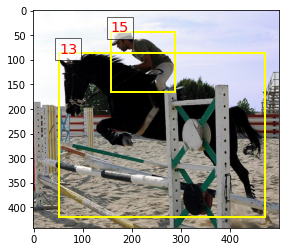

In [7]:
dataset[3]

#### 带有数据增强

In [8]:
def flip(img, boxes):
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    w = img.width
    if boxes.shape[0] != 0:
        xmin = w - boxes[:, 2]
        xmax = w - boxes[:, 0]
        boxes[:, 2] = xmax
        boxes[:, 0] = xmin
    return img, boxes

In [9]:
class VOCDataset(torch.utils.data.Dataset):
    
    CLASSES_NAME = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )

    def __init__(self, root_dir, resize_size=[800, 1333], split='trainval', 
                 use_difficult=False, is_train=True, augment=None):
        """初始化主要工作：
            0）告知文件路径
            1）self.img_ids 图片名称列表
            2）self.name2id 标签类别到整数的映射字典
        """
        self.root = root_dir
        self.imgset = split
        self.use_difficult = use_difficult
        
        # %s 字符串格式符 字符串作为模板。
        self._annopath = os.path.join(self.root, "Annotations", "%s.xml")
        self._imgpath = os.path.join(self.root, "JPEGImages", "%s.jpg")
        self._imgsetpath = os.path.join(self.root, "ImageSets", "Main", "%s.txt")
        
        with open(self._imgsetpath % self.imgset) as f:
            self.img_ids = f.readlines()
        self.img_ids = [x.strip() for x in self.img_ids]

    
        self.name2id = dict(zip(VOCDataset.CLASSES_NAME, range(len(VOCDataset.CLASSES_NAME))))
        self.id2name = {v: k for k, v in self.name2id.items()}
        
        self.resize_size = resize_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        self.train = is_train
        self.augment = augment
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):

        img_id = self.img_ids[index];print(img_id)
        
        img_path = self._imgpath % img_id ;print(img_path)
        # img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # 读入rgb图像，，，
        img = Image.open(img_path)  # ，，，同上
        
        
        label_path = self._annopath % img_id ;print(label_path)
        boxes, classes = self.get_xml_label(label_path)
        
        if self.train:
            if random.random() < 0.5:
                img, boxes = flip(img, boxes)
            if self.augment is not None:
                img, boxes = self.augment(img, boxes)
        # 可视化一下：
        plt.imshow(img)
        current_axis = plt.gca()
        for i, box in enumerate(boxes):
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]

            label = classes[i]
            current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))  
            current_axis.text(xmin, ymin, label, size='x-large', color='red', bbox={'facecolor':'white', 'alpha':0.6})   
        
        # 数据格式转换  都转换成张量
        img = transforms.ToTensor()(img)
        boxes = torch.from_numpy(boxes)
        classes = torch.LongTensor(classes)

        return img.shape, boxes, classes
    
    def get_xml_label(self, label_path):
    
        anno = ET.parse(label_path).getroot()
        boxes = []
        classes = []
        for obj in anno.iter("object"):
            # 放弃难分辨的图片
            difficult = int(obj.find("difficult").text) == 1
            if not self.use_difficult and difficult:
                continue

            _box = obj.find("bndbox")
            box = [
                _box.find("xmin").text,
                _box.find("ymin").text,
                _box.find("xmax").text,
                _box.find("ymax").text,
            ]
            # 1 对一下 这个框像素点位置
            TO_REMOVE = 1
            box = tuple(
                map(lambda x: x - TO_REMOVE, list(map(float, box)))
            )
            boxes.append(box)
            # 2 找一下这个框的类别码
            name = obj.find("name").text.lower().strip()
            classes.append(self.name2id[name])
            
        boxes = np.array(boxes, dtype=np.float32)
        return boxes, classes
    
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData')

2008_000009
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/JPEGImages/2008_000009.jpg
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/Annotations/2008_000009.xml


(torch.Size([3, 375, 500]), tensor([[207., 160., 284., 220.],
         [  1., 166.,  36., 217.]]), tensor([10, 10]))

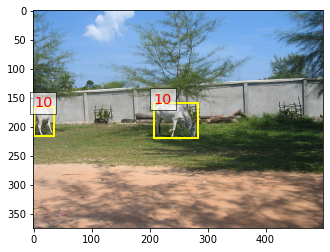

In [10]:
dataset[4]

In [16]:
def colorJitter(img, boxes, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1):
    img = transforms.ColorJitter(brightness=brightness,
                                 contrast=contrast, saturation=saturation, hue=hue)(img)
    return img, boxes

def random_rotation(img, boxes, degree=10):
    d = random.uniform(-degree, degree)
    w, h = img.size
    rx0, ry0 = w / 2.0, h / 2.0
    img = img.rotate(d)
    a = -d / 180.0 * math.pi
    boxes = torch.from_numpy(boxes)
    new_boxes = torch.zeros_like(boxes)
    new_boxes[:, 0] = boxes[:, 1]
    new_boxes[:, 1] = boxes[:, 0]
    new_boxes[:, 2] = boxes[:, 3]
    new_boxes[:, 3] = boxes[:, 2]
    for i in range(boxes.shape[0]):
        ymin, xmin, ymax, xmax = new_boxes[i, :]
        xmin, ymin, xmax, ymax = float(xmin), float(ymin), float(xmax), float(ymax)
        x0, y0 = xmin, ymin
        x1, y1 = xmin, ymax
        x2, y2 = xmax, ymin
        x3, y3 = xmax, ymax
        z = torch.FloatTensor([[y0, x0], [y1, x1], [y2, x2], [y3, x3]])
        tp = torch.zeros_like(z)
        tp[:, 1] = (z[:, 1] - rx0) * math.cos(a) - (z[:, 0] - ry0) * math.sin(a) + rx0
        tp[:, 0] = (z[:, 1] - rx0) * math.sin(a) + (z[:, 0] - ry0) * math.cos(a) + ry0
        ymax, xmax = torch.max(tp, dim=0)[0]
        ymin, xmin = torch.min(tp, dim=0)[0]
        new_boxes[i] = torch.stack([ymin, xmin, ymax, xmax])
    new_boxes[:, 1::2].clamp_(min=0, max=w - 1)
    new_boxes[:, 0::2].clamp_(min=0, max=h - 1)
    boxes[:, 0] = new_boxes[:, 1]
    boxes[:, 1] = new_boxes[:, 0]
    boxes[:, 2] = new_boxes[:, 3]
    boxes[:, 3] = new_boxes[:, 2]
    boxes = boxes.numpy()
    return img, boxes

def _box_inter(box1, box2):
    tl = torch.max(box1[:, None, :2], box2[:, :2])  # [n,m,2]
    br = torch.min(box1[:, None, 2:], box2[:, 2:])  # [n,m,2]
    hw = (br - tl).clamp(min=0)  # [n,m,2]
    inter = hw[:, :, 0] * hw[:, :, 1]  # [n,m]
    return inter

def random_crop_resize(img, boxes, crop_scale_min=0.2, 
                       aspect_ratio=[3. / 4, 4. / 3], 
                       remain_min=0.7, attempt_max=10):
    success = False
    boxes = torch.from_numpy(boxes)
    for attempt in range(attempt_max):
        # choose crop size
        area = img.size[0] * img.size[1]
        target_area = random.uniform(crop_scale_min, 1.0) * area
        aspect_ratio_ = random.uniform(aspect_ratio[0], aspect_ratio[1])
        w = int(round(math.sqrt(target_area * aspect_ratio_)))
        h = int(round(math.sqrt(target_area / aspect_ratio_)))
        if random.random() < 0.5:
            w, h = h, w
        # if size is right then random crop
        if w <= img.size[0] and h <= img.size[1]:
            x = random.randint(0, img.size[0] - w)
            y = random.randint(0, img.size[1] - h)
            # check
            crop_box = torch.FloatTensor([[x, y, x + w, y + h]])
            inter = _box_inter(crop_box, boxes)  # [1,N] N can be zero
            box_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # [N]
            mask = inter > 0.0001  # [1,N] N can be zero
            inter = inter[mask]  # [1,S] S can be zero
            box_area = box_area[mask.view(-1)]  # [S]
            box_remain = inter.view(-1) / box_area  # [S]
            if box_remain.shape[0] != 0:
                if bool(torch.min(box_remain > remain_min)):
                    success = True
                    break
            else:
                success = True
                break
    if success:
        img = img.crop((x, y, x + w, y + h))
        boxes -= torch.Tensor([x, y, x, y])
        boxes[:, 1::2].clamp_(min=0, max=h - 1)
        boxes[:, 0::2].clamp_(min=0, max=w - 1)
        # ow, oh = (size, size)
        # sw = float(ow) / img.size[0]
        # sh = float(oh) / img.size[1]
        # img = img.resize((ow,oh), Image.BILINEAR)
        # boxes *= torch.FloatTensor([sw,sh,sw,sh])
    boxes = boxes.numpy()
    return img, boxes

In [17]:
class Transforms(object):

    def __call__(self, img, boxes):
        if random.random() < 0.3:
            img, boxes = colorJitter(img, boxes)
        if random.random() < 0.5:
            img, boxes = random_rotation(img, boxes)
        if random.random() < 0.5:
            img, boxes = random_crop_resize(img, boxes)
        return img, boxes

In [18]:
transform = Transforms()

In [19]:
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData', augment=transform)

2008_000008
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/Annotations/2008_000008.xml


(torch.Size([3, 402, 431]), tensor([[  0.0000,  68.1115, 421.2741, 401.0000],
         [105.2978,  29.3883, 241.1598, 157.5800]]), tensor([13, 15]))

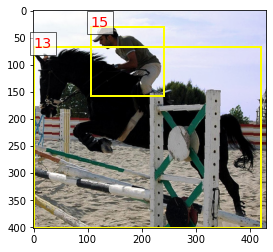

In [22]:
dataset[3]

### 图像和标签处理（数据增强）
* **目标检测任务中，resize需要保留长宽比例，然后用padding补上短边的缺失部分。**

In [23]:
class VOCDataset(torch.utils.data.Dataset):
    
    CLASSES_NAME = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor",
    )

    def __init__(self, root_dir, resize_size=[800, 1333], split='trainval', 
                 use_difficult=False, is_train=True, augment=None):
        """初始化主要工作：
            0）告知文件路径
            1）self.img_ids 图片名称列表
            2）self.name2id 标签类别到整数的映射字典
        """
        self.root = root_dir
        self.imgset = split
        self.use_difficult = use_difficult
        
        # %s 字符串格式符 字符串作为模板。
        self._annopath = os.path.join(self.root, "Annotations", "%s.xml")
        self._imgpath = os.path.join(self.root, "JPEGImages", "%s.jpg")
        self._imgsetpath = os.path.join(self.root, "ImageSets", "Main", "%s.txt")
        
        with open(self._imgsetpath % self.imgset) as f:
            self.img_ids = f.readlines()
        self.img_ids = [x.strip() for x in self.img_ids]

    
        self.name2id = dict(zip(VOCDataset.CLASSES_NAME, range(len(VOCDataset.CLASSES_NAME))))
        self.id2name = {v: k for k, v in self.name2id.items()}
        
        self.resize_size = resize_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        self.train = is_train
        self.augment = augment
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):

        img_id = self.img_ids[index];print(img_id)
        
        img_path = self._imgpath % img_id ;print(img_path)
        # img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # 读入rgb图像，，，
        img = Image.open(img_path)  # ，，，同上
        
        
        label_path = self._annopath % img_id ;print(label_path)
        boxes, classes = self.get_xml_label(label_path)
        
        if self.train:
            if random.random() < 0.5:
                img, boxes = flip(img, boxes)
            if self.augment is not None:
                img, boxes = self.augment(img, boxes)
       
        img = np.array(img)
        img, boxes = self.preprocess_img_boxes(img, boxes, self.resize_size)
        # 数据可视化
        plt.imshow(img)
        current_axis = plt.gca()
        for i, box in enumerate(boxes):
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]

            label = classes[i]
            current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))  
            current_axis.text(xmin, ymin, label, size='x-large', color='red', bbox={'facecolor':'white', 'alpha':0.6})   
            
        # 数据格式转换  都转换成张量
        img = transforms.ToTensor()(img)
        boxes = torch.from_numpy(boxes)
        classes = torch.LongTensor(classes)

        return img.shape, boxes, classes
    
    def get_xml_label(self, label_path):
    
        anno = ET.parse(label_path).getroot()
        boxes = []
        classes = []
        for obj in anno.iter("object"):
            # 放弃难分辨的图片
            difficult = int(obj.find("difficult").text) == 1
            if not self.use_difficult and difficult:
                continue

            _box = obj.find("bndbox")
            box = [
                _box.find("xmin").text,
                _box.find("ymin").text,
                _box.find("xmax").text,
                _box.find("ymax").text,
            ]
            # 1 对一下 这个框像素点位置
            TO_REMOVE = 1
            box = tuple(
                map(lambda x: x - TO_REMOVE, list(map(float, box)))
            )
            boxes.append(box)
            # 2 找一下这个框的类别码
            name = obj.find("name").text.lower().strip()
            classes.append(self.name2id[name])
            
        boxes = np.array(boxes, dtype=np.float32)
        return boxes, classes

    def preprocess_img_boxes(self, image, boxes, input_ksize):
        """
        resize image and bboxes
        Returns
        image_paded: input_ksize
        bboxes: [None,4]
        """
        min_side, max_side = input_ksize
        h, w, _ = image.shape

        smallest_side = min(w, h)
        largest_side = max(w, h)
        
        scale = min_side / smallest_side  # 选择合适的缩放比scale
        if largest_side * scale > max_side: 
            scale = max_side / largest_side  
            
        nw, nh = int(scale * w), int(scale * h)  #  注意：cv.imread().shape() --> h,w,c ; cv.resize(img, (w, h)
        image_resized = cv2.resize(image, (nw, nh))  # 将图像的长宽放缩到input_ksize范围内
        # 图形下采样到最后小了32倍，这里在图像输入时做一些padding
        pad_h = 32 - nh % 32  # pad_h + (nh % 32) = 32  # 想要下采样32倍后特征图的大小为32
        pad_w = 32 - nw % 32
        
        # 生成一张空图用于填充
        image_paded = np.zeros(shape=[nh + pad_h, nw + pad_w, 3], dtype=np.uint8)
        image_paded[:nh, :nw, :] = image_resized

        if boxes is None:
            return image_paded
        else:
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale
            return image_paded, boxes
        
        
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData')

2008_000008
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012/Annotations/2008_000008.xml


(torch.Size([3, 832, 928]), tensor([[ 54.2986, 155.6561, 810.8597, 758.3710],
         [383.7104,  77.8281, 620.8145, 300.4525]]), tensor([13, 15]))

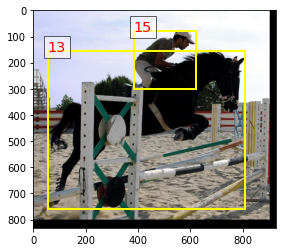

In [51]:
dataset[3]

### 标签对齐
* **image：[N,C,H,W] -- 需要保持图片大小一致（H,W）**
* **label：[N,Num,4] -- 需要保持每张照片中的BBox个数相同（Num），利用[-1,-1,-1,-1]补齐**

In [54]:
class VOCDataset(torch.utils.data.Dataset):
    
    CLASSES_NAME = (
        "__background__ ",
        "aeroplane",
        "bicycle",
        "bird",
        "boat",
        "bottle",
        "bus",
        "car",
        "cat",
        "chair",
        "cow",
        "diningtable",
        "dog",
        "horse",
        "motorbike",
        "person",
        "pottedplant",
        "sheep",
        "sofa",
        "train",
        "tvmonitor")

    def __init__(self, root_dir, resize_size=[800, 1333], split='trainval', 
                 use_difficult=False, is_train=True, augment=None):
        """初始化主要工作：
            0）告知文件路径
            1）self.img_ids 图片名称列表
            2）self.name2id 标签类别到整数的映射字典
        """
        self.root = root_dir
        self.imgset = split
        self.use_difficult = use_difficult
        
        # %s 字符串格式符 字符串作为模板。
        self._annopath = os.path.join(self.root, "Annotations", "%s.xml")
        self._imgpath = os.path.join(self.root, "JPEGImages", "%s.jpg")
        self._imgsetpath = os.path.join(self.root, "ImageSets", "Main", "%s.txt")
        
        with open(self._imgsetpath % self.imgset) as f:
            self.img_ids = f.readlines()
        self.img_ids = [x.strip() for x in self.img_ids]

    
        self.name2id = dict(zip(VOCDataset.CLASSES_NAME, range(len(VOCDataset.CLASSES_NAME))))
        self.id2name = {v: k for k, v in self.name2id.items()}
        
        self.resize_size = resize_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        
        self.train = is_train
        self.augment = augment
        
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):

        img_id = self.img_ids[index]
        
        img_path = self._imgpath % img_id 
        # img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # 读入rgb图像，，，
        img = Image.open(img_path)  # ，，，同上
        
        
        label_path = self._annopath % img_id
        boxes, classes = self.get_xml_label(label_path)
        
        if self.train:
            if random.random() < 0.5:
                img, boxes = flip(img, boxes)
            if self.augment is not None:
                img, boxes = self.augment(img, boxes)
       
        img = np.array(img)
        img, boxes = self.preprocess_img_boxes(img, boxes, self.resize_size)
        
        # 数据格式转换  都转换成张量
        img = transforms.ToTensor()(img)
        boxes = torch.from_numpy(boxes)
        classes = torch.LongTensor(classes)

        return img, boxes, classes
    
    def get_xml_label(self, label_path):
    
        anno = ET.parse(label_path).getroot()
        boxes = []
        classes = []
        for obj in anno.iter("object"):
            # 放弃难分辨的图片
            difficult = int(obj.find("difficult").text) == 1
            if not self.use_difficult and difficult:
                continue

            _box = obj.find("bndbox")
            box = [
                _box.find("xmin").text,
                _box.find("ymin").text,
                _box.find("xmax").text,
                _box.find("ymax").text,
            ]
            # 1 对一下 这个框像素点位置
            TO_REMOVE = 1
            box = tuple(
                map(lambda x: x - TO_REMOVE, list(map(float, box)))
            )
            boxes.append(box)
            # 2 找一下这个框的类别码
            name = obj.find("name").text.lower().strip()
            classes.append(self.name2id[name])
            
        boxes = np.array(boxes, dtype=np.float32)
        return boxes, classes

    def preprocess_img_boxes(self, image, boxes, input_ksize):
        """
        resize image and bboxes
        Returns
        image_paded: input_ksize
        bboxes: [None,4]
        """
        min_side, max_side = input_ksize
        h, w, _ = image.shape

        smallest_side = min(w, h)
        largest_side = max(w, h)
        
        scale = min_side / smallest_side  # 选择合适的缩放比scale
        if largest_side * scale > max_side: 
            scale = max_side / largest_side  
            
        nw, nh = int(scale * w), int(scale * h)  #  注意：cv.imread().shape() --> h,w,c ; cv.resize(img, (w, h)
        image_resized = cv2.resize(image, (nw, nh))  # 将图像的长宽放缩到input_ksize范围内
        # 图形下采样到最后小了32倍，这里在图像输入时做一些padding
        pad_h = 32 - nh % 32  # pad_h + (nh % 32) = 32  # 想要下采样32倍后特征图的大小为32
        pad_w = 32 - nw % 32
        
        # 生成一张空图用于填充
        image_paded = np.zeros(shape=[nh + pad_h, nw + pad_w, 3], dtype=np.uint8)
        image_paded[:nh, :nw, :] = image_resized

        if boxes is None:
            return image_paded
        else:
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale
            return image_paded, boxes

    def collate_fn(self, data):
        
        imgs_list, boxes_list, classes_list = zip(*data)
        assert len(imgs_list) == len(boxes_list) == len(classes_list)
        # assert函数，条件成立继续往下运行，否则报错。
        batch_size = len(boxes_list)
        print('batch_size:', batch_size)
        
        pad_imgs_list = []
        pad_boxes_list = []
        pad_classes_list = []

        h_list = [int(s.shape[1]) for s in imgs_list]
        w_list = [int(s.shape[2]) for s in imgs_list]
        max_h = np.array(h_list).max()
        max_w = np.array(w_list).max()
        for i in range(batch_size):
            img = imgs_list[i]
            pad_imgs_list.append(transforms.Normalize(self.mean, self.std, inplace=True)(
                torch.nn.functional.pad(img, (0, int(max_w - img.shape[2]), 0, int(max_h - img.shape[1])), value=0.)))

        # 一个batch中有几张图片， 每个图片中有一个或几个框， 找到一张图片最多能有几个框
        max_num = 0
        for i in range(batch_size):
            n = boxes_list[i].shape[0]
            if n > max_num:
                max_num = n
                
        for i in range(batch_size):
            pad_boxes_list.append(
                torch.nn.functional.pad(boxes_list[i], (0, 0, 0, max_num - boxes_list[i].shape[0]), value=-1))
            pad_classes_list.append(
                torch.nn.functional.pad(classes_list[i], (0, max_num - classes_list[i].shape[0]), value=-1))

        batch_boxes = torch.stack(pad_boxes_list)
        batch_classes = torch.stack(pad_classes_list)
        batch_imgs = torch.stack(pad_imgs_list)

        return batch_imgs, batch_boxes, batch_classes

In [59]:
dataset = VOCDataset("/home/elimen/Data/deepshare/Object Detection/课件完全版/VOCdevkit/VOC2012", split='trainval_demoData')

data = (dataset[0], dataset[2], dataset[3])
print(type(data))
imgs, boxes, classes = dataset.collate_fn(data)

print(boxes, '\n', classes, '\n')

print(imgs.shape, boxes.shape, classes.shape)

<class 'tuple'>
batch_size: 3
tensor([[[ 7.0400e+01,  2.1333e+01,  9.5360e+02,  6.2293e+02],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00]],

        [[ 1.5573e+02,  4.8853e+02,  1.0667e+03,  6.2293e+02],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00]],

        [[ 5.4299e+01,  1.5566e+02,  8.1086e+02,  7.5837e+02],
         [ 3.8371e+02,  7.7828e+01,  6.2081e+02,  3.0045e+02]]]) 
 tensor([[20, -1],
        [ 4, -1],
        [13, 15]]) 

torch.Size([3, 3, 832, 1088]) torch.Size([3, 2, 4]) torch.Size([3, 2])
